# Data Preprocess

#### This notebook read the data from SVHN dataset, then do the preprocess to the data and save them as .mat format which will use later
#### This following codes mainly devided into 2 parts:
#### 1 Data Preprocess for training set
#### 2 Data Preprocess for testing set

#### Before running this notebook, please download the SVHN dataset from http://ufldl.stanford.edu/housenumbers/ 

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. 

#### The dataset is divided into two parts 
* Format 1: Full Numbers: train.tar.gz, test.tar.gz , extra.tar.gz (Note: for non-commercial use only)
* Format 2: Cropped Digits: train_32x32.mat, test_32x32.mat , extra_32x32.mat (Note: for non-commercial use only)

#### In this project we only use the first part, so you only need to download train.tar.gz, test.tar.gz from the Format 1

These are the original, variable-resolution, color house-number images with character level bounding boxes, as shown in the examples images above. (The blue bounding boxes here are just for illustration purposes. The bounding box information are stored in digitStruct.mat instead of drawn directly on the images in the dataset.) Each tar.gz file contains the orignal images in png format, together with a digitStruct.mat file, which can be loaded using Matlab. The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Eg: digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image. 

## 1 Data Preprocess for Training Set

### (1) Read image from SVHN dataset

In [1]:
from utils.dataprocess import *
from scipy import misc
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import scipy.io as scio
import imageio
import h5py
import cv2
import os
import sys
import gzip
import gc 

#### Make sure you cange the folder_path to your local directory whre SVHN train saved

In [2]:
folder_path = "./train/" #change that value before running
img_type = ".png"
img_num = 33402
X_train = read_from_folder(folder_path, img_type, img_num)

show some image information in the dataset

In [3]:
print("X_train length {}".format(len(X_train)))
print("Every element in X_train is a image with different shape")
print("1.png shape {}".format(X_train[0].shape))
print("2.png shape {}".format(X_train[1].shape))

X_train length 33401
Every element in X_train is a image with different shape
1.png shape (350, 741, 3)
2.png shape (83, 199, 3)


### (2) Crop the image to 54 x 54
Based on the paper:
We preprocess the dataset in the following way – first we find the small rectangular bounding box that will contain individual character bounding boxes. We then expand this bounding box by 30% in both the x and the y direction, crop the image to that bounding box and resize the crop to 64 × 64 pixels. We then crop a 54 × 54 pixel image from a random location within the 64 × 64 pixel image. This means we generated several randomly shifted versions of each training example, in order to increase the size of the dataset. 

In [4]:
mat_h5pyFile = h5py.File('./train/digitStruct.mat') #change that value before running
X_train_crop = []
X_train_label = []
for i in range(img_num-1):
    orig_image = np.array(X_train[i])
    box_inf = get_image_box(i, mat_h5pyFile)
    label = box_inf['label']
    X_train_label.append(''.join(str(int(x%10)) for x in label)) #0->10; 1->1; 2->2; ...; 9->9
    X_train_label.append(''.join(str(int(x%10)) for x in label)) #0->10; 1->1; 2->2; ...; 9->9
    crop_imag, _ = image_crop(orig_image,box_inf)
    #crop_resize_imag = cv2.resize(crop_imag, dsize=(54, 54), interpolation=cv2.INTER_CUBIC)
    #crop_resize_imag2 = np.roll(crop_resize_imag, shift=(random.randint(0,7),random.randint(0,7)), axis=(0,1))
    crop_resize_imag = cv2.resize(crop_imag, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    rand1 = random.randint(0,9)
    rand2 = random.randint(0,9)
    rand3 = random.randint(0,9)
    rand4 = random.randint(0,9)
    crop_resize_imag1 = crop_resize_imag[rand1: rand1+54, rand2: rand2+54, :]
    crop_resize_imag2 = crop_resize_imag[rand3: rand3+54, rand4: rand4+54, :]
    X_train_crop.append(crop_resize_imag1)     
    X_train_crop.append(crop_resize_imag2)   

### (3) Save the data to .mat file
save the croped train images in to Xtrain.mat and the label of the images into Ytrain.mat

change the X_train_mat Y_train_mat to where you want to save the .mat file

In [5]:
X_train_mat = './Xtrain.mat' #change that value before running
Y_train_mat = './Ytrain.mat' #change that value before running
scio.savemat(X_train_mat, {'Xtrain':X_train_crop})
scio.savemat(Y_train_mat, {'Ytrain':X_train_label})

### (4) Show the result
Red boxes are get from /train/digitStruct.mat blue box is the implementation of data preprocess from the paper: "first we find the small rectangular bounding box that will contain individual character bounding boxes. We then expand this bounding box by 30% in both the x and the y direction"

Information get from the mat file: {'height': [35, 35, 35], 'left': [63, 91, 119], 'top': [13, 23, 34], 'width': [27, 28, 25], 'label': [2, 8, 10]}
Value of the image is: 280


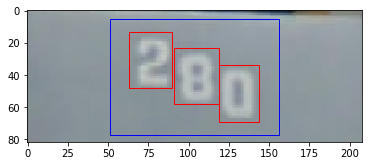

In [6]:
plt.imshow(X_train[215])
box_show = get_image_box(215, mat_h5pyFile)
print('Information get from the mat file: {}'.format(box_show))
print('Value of the image is: {}'.format(''.join(str(int(x%10)) for x in box_show['label'])))
currentAxis=plt.gca()
rect1=patches.Rectangle((box_show['left'][0], box_show['top'][0]),box_show['width'][0] , box_show['height'][0],linewidth=1,edgecolor='r',facecolor='none')
rect2=patches.Rectangle((box_show['left'][1], box_show['top'][1]),box_show['width'][1] , box_show['height'][1],linewidth=1,edgecolor='r',facecolor='none')
rect3=patches.Rectangle((box_show['left'][2], box_show['top'][2]),box_show['width'][2] , box_show['height'][2],linewidth=1,edgecolor='r',facecolor='none')
currentAxis.add_patch(rect1)
currentAxis.add_patch(rect2)
currentAxis.add_patch(rect3)
crop_imag_show, image_crop_range_show = image_crop(np.array(X_train[215]),box_show)
rect4=patches.Rectangle((51, 5),156-51, 77-5,linewidth=1,edgecolor='b',facecolor='none')
currentAxis.add_patch(rect4)

##### Crop to a 54 x 54 image

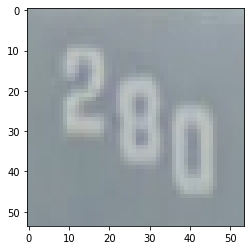

In [7]:
crop_resize_imag_show = cv2.resize(crop_imag_show, dsize=(54, 54), interpolation=cv2.INTER_CUBIC)
plt.imshow(crop_resize_imag_show)

In [8]:
%reset -f

## 2 Data Preprocess for Testing Set
The process of preprocess for Testing Set is the same as preprocess for Training Set

### (1) Read image from SVHN dataset

In [14]:
from utils.dataprocess import *
from scipy import misc
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import scipy.io as scio
import imageio
import h5py
import cv2
import os
import sys
import gzip
import gc 

In [10]:
folder_path = "./test/"
img_type = ".png"
img_num = 13068
X_test = read_from_folder(folder_path, img_type, img_num)

In [11]:
print("X_test length {}".format(len(X_test)))
print("Every element in X_test is a image with different shape")
print("1.png shape {}".format(X_test[0].shape))
print("2.png shape {}".format(X_test[1].shape))

X_test length 13067
Every element in X_test is a image with different shape
1.png shape (47, 99, 3)
2.png shape (48, 182, 3)


### (2) Crop the image to 54 x 54

In [12]:
mat_h5pyFile = h5py.File('./test/digitStruct.mat') #change that value before running
X_test_crop = []
X_test_label = []
for i in range(img_num-1):
    orig_image = np.array(X_test[i])
    box_inf = get_image_box(i, mat_h5pyFile)
    label = box_inf['label']
    X_test_label.append(''.join(str(int(x%10)) for x in label)) #0->10; 1->1; 2->2; ...; 9->9
    crop_imag, _ = image_crop(orig_image,box_inf)
    crop_resize_imag = cv2.resize(crop_imag, dsize=(54, 54), interpolation=cv2.INTER_CUBIC)
    X_test_crop.append(crop_resize_imag)     

### (3) Save the data to .mat file

In [16]:
X_test_mat = './Xtest.mat' #change that value before running
Y_test_mat = './Ytest.mat' #change that value before running
scio.savemat(X_test_mat, {'Xtest':X_test_crop})
scio.savemat(Y_test_mat, {'Ytest':X_test_label})